# Feature engineering

В предишната тетрадка опитахме различни неща с модела. Но семплирането на модела не даде смислен резултат.

Ще опитаме да направим по-добри (и повече) feature-и за всяка от плочките и да оставим невронната мрежа да си сврърши работата.

Нека заредим малко модули и данни...

In [1]:
import numpy as np
import os
import random

import config
from scenario import *
from tileset import *

In [2]:
scenarios = []
scenarios += process_scenarios(os.path.join(config.STARCRAFT_ROOT, 'Maps'))
for directory in config.MAP_DIRECTORIES:
    scenarios += process_scenarios(directory)

tiny_jungle_scenarios = [x for x in scenarios if x.tileset == Tileset.JUNGLE]
tiny_jungle_scenarios = [x for x in scenarios if x.alliances == x.human_players == 2 and x.width == x.height == 64]

len(scenarios)

561

In [3]:
import matplotlib.pyplot as plt

## Идея 1: feature-и от свойства на плочки?

Интуитивен начин да направим feature-и би бил да вземем всички 16 мини-плочки, от които е направена всяка плочка. На базата на свойствата на тези мини-плочки и на свойствата на самата плочка можем да направим векторите ни с feature-и.

След известно ровене в плочките забелязваме нещо...

1074 0
[[0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


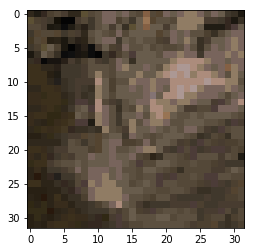

In [4]:
lost_temple = next(filter(lambda x: x.name == 'The Lost Temple', scenarios))

plt.imshow(lost_temple.tiles[65, 8].graphics)
print(lost_temple.tiles[65, 8].index // 16, lost_temple.tiles[65, 8].index % 16)
print(np.vectorize(lambda x: x.height)(lost_temple.tiles[65, 8].minitiles))
print(np.vectorize(lambda x: x.ramp)(lost_temple.tiles[65, 8].minitiles))

Това е част от изкачване от "lowground" към "highground". Свойствата му са напълно безполезни. На практика не можем да използваме височината на плочката като feature. Нито флага `ramp`. Други флагове може би ще идентифицират плочката, но едва ли ще бъде достатъчно за уникална идентификация.

## Идея 2: One hot encoding (with a twist)

При имплементацията на парсера за `Tileset` данни, забелязваме че има два типа плочки. Първите са нормални части от терена. Вторите са "нещица" (doodads) разхвърляни по картата.

Първите са разпръснати в групи от по до 16 плочки. Свойствата им са еднотипни в рамките на групата. Разликата е единствено във визуализацията им. Плочките в една група са взаимнозаменяеми.

Вторите обикновено са препятствия по терена, чиято графика е по-голяма от размерите на единична плочка. За да се получи "нещото", плочките му трябва да бъдат използвани в конкретен ред. Плочките от този тип също са в групи, но плочките не са взаимнозаменяеми в рамките на група.

Идеята е плочките от първи тип да кодираме като `(уникален-номер-на-група, позиция-в-групата)`, а плочките от втори тип като `(уникален-номер-на-плочка, 0.5)`, където `уникален-номер-на-група` и `уникален-номер-на-плочка` са две непресичащи се множества от последователни цели числа.

In [5]:
tiles = Tileset.JUNGLE.tiles
terrain_tiles = (tile for tile in tiles if not tile.is_empty and not tile.is_doodad)
doodad_tiles = (tile for tile in tiles if not tile.is_empty and tile.is_doodad)

used_tiles = set()

groups = dict()
tile_features = dict()

for tile in terrain_tiles:
    if tile in tile_features:
        continue
    if not tile.group_id in groups:
        groups[tile.group_id] = len(groups)
    tile_features[tile] = (groups[tile.group_id], (tile.group_offset + 1) / 16)

group_count = len(groups)
del(groups)
for tile in doodad_tiles:
    if tile in tile_features:
        continue
    group_count += 1
    tile_features[tile] = (group_count, 0.5)

In [6]:
print(group_count)

2086


В момента сме кодирали всяка плочка с двойка числа (x, y), където x ∈ [0-2413), y ∈ (0-1]. Може да се каже, че при втория параметър има някаква наредба. При вървият обаче - не. Ще му направим one hot encoding.

In [7]:
one_hot_tile_features = dict()

for tile, (group_id, group_offset) in tile_features.items():
    one_hot_tile_features[tile] = np.zeros(group_count + 1)
    one_hot_tile_features[tile][group_id] = 1.0
    one_hot_tile_features[tile][-1] = group_offset

del tile_features